In [80]:
library(dplyr)
library(lme4)
library(nlme)
library(purrr)
library(performance)
library(tibble)
library(MuMIn)
library(here)
library(reactablefmtr)
library(emmeans)
library(car)
library(ggplot2)
library(modelr)
require(vegan)
require(knitr)
require(ggpubr)
library(ggeffects)
library(janitor)
library(factoextra)

In [81]:
setwd(here::here())

In [156]:
# Load all joined dataset
source("./scripts/code_join_data_full_dataset.R")

In [157]:
# Load custom made functions
source("./R/functions_models.R")
source("./R/function_plots.R")
source("./R/function_validation_plots.R")
source("./R/function_for_inference_emmeans_and_percentage_diff.R")


In [83]:
# set plot dimensions
options(repr.plot.width = 15)
options(repr.plot.height = 10)

__For running each peice of code press shift + Enter__

# __Q3:How do functional traits, treatment, and N-fixing status interact to influence seedling-level growth rates and biomass accumulation?__

## pcA


In [84]:
head(data_for_models)

,spcode,treatment,nfixer,init_height,total_biomass,agr,rgr,rgr_slope,root_shoot_ratio,rmf,smf,lmf,amax,gs,wue,d13c,pnue,Narea_g_m2,sla
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,ec,no_additions,fixer,17.0,3.915,0.2058824,0.008326423,0.1573281,0.7369122,42.42656,23.57599,33.99745,23.420,0.177,12.682,-29.52088,163.02889,2.012140,0.02333615
6,ec,no_additions,fixer,25.0,6.284,0.2352941,0.006915137,0.1342702,0.9094500,47.62890,26.14577,26.22533,23.543,0.257,7.296,-29.39493,94.78208,3.479136,0.01321698
7,ec,no_additions,fixer,14.0,5.798,0.2117647,0.009725630,0.1815346,1.2728342,56.00207,17.10935,26.88858,21.427,0.210,8.928,-28.95120,66.80843,4.492271,0.01081831
8,ec,no_additions,fixer,16.0,3.857,0.1705882,0.007589858,0.1219915,0.9499494,48.71662,21.31190,29.97148,23.673,0.193,11.492,-29.91484,145.71489,2.275544,0.02328424
9,ec,plus_water_nutrients,fixer,20.5,4.974,0.2470588,0.008297277,0.1639320,1.0376895,50.92481,26.75915,22.31604,19.670,0.257,4.574,-30.27865,78.54372,3.507751,0.01122583
10,ec,plus_water_nutrients,fixer,21.0,15.055,0.4235294,0.011747398,0.2042577,1.4173089,58.63168,18.79110,22.57722,21.950,0.267,5.023,-29.10113,145.60331,2.111539,0.02207814


In [209]:
# Select variables that are going to be used in the model
data_for_models <-
    data_for_models %>%

    clean_names() %>%
    # Select columns needed for regression
    dplyr::select(spcode, treatment, nfixer, init_height,

                  # Performance measures
                  total_biomass, rgr, root_shoot_ratio,

                  # physiology traits
                  amax, gs, wue,

                  # Leaf traits
                  narea_g_m2, d13c, sla) %>%
    clean_names()

In [211]:
# Scale and center traits
data_traits_scaled <-
    data_for_models %>%
        select(-c(total_biomass, rgr, root_shoot_ratio, init_height)) %>%
        mutate(across(where(is.numeric), scale))

In [212]:
pca_traits <- princomp(data_traits_scaled[,c(4:ncol(data_traits_scaled))])

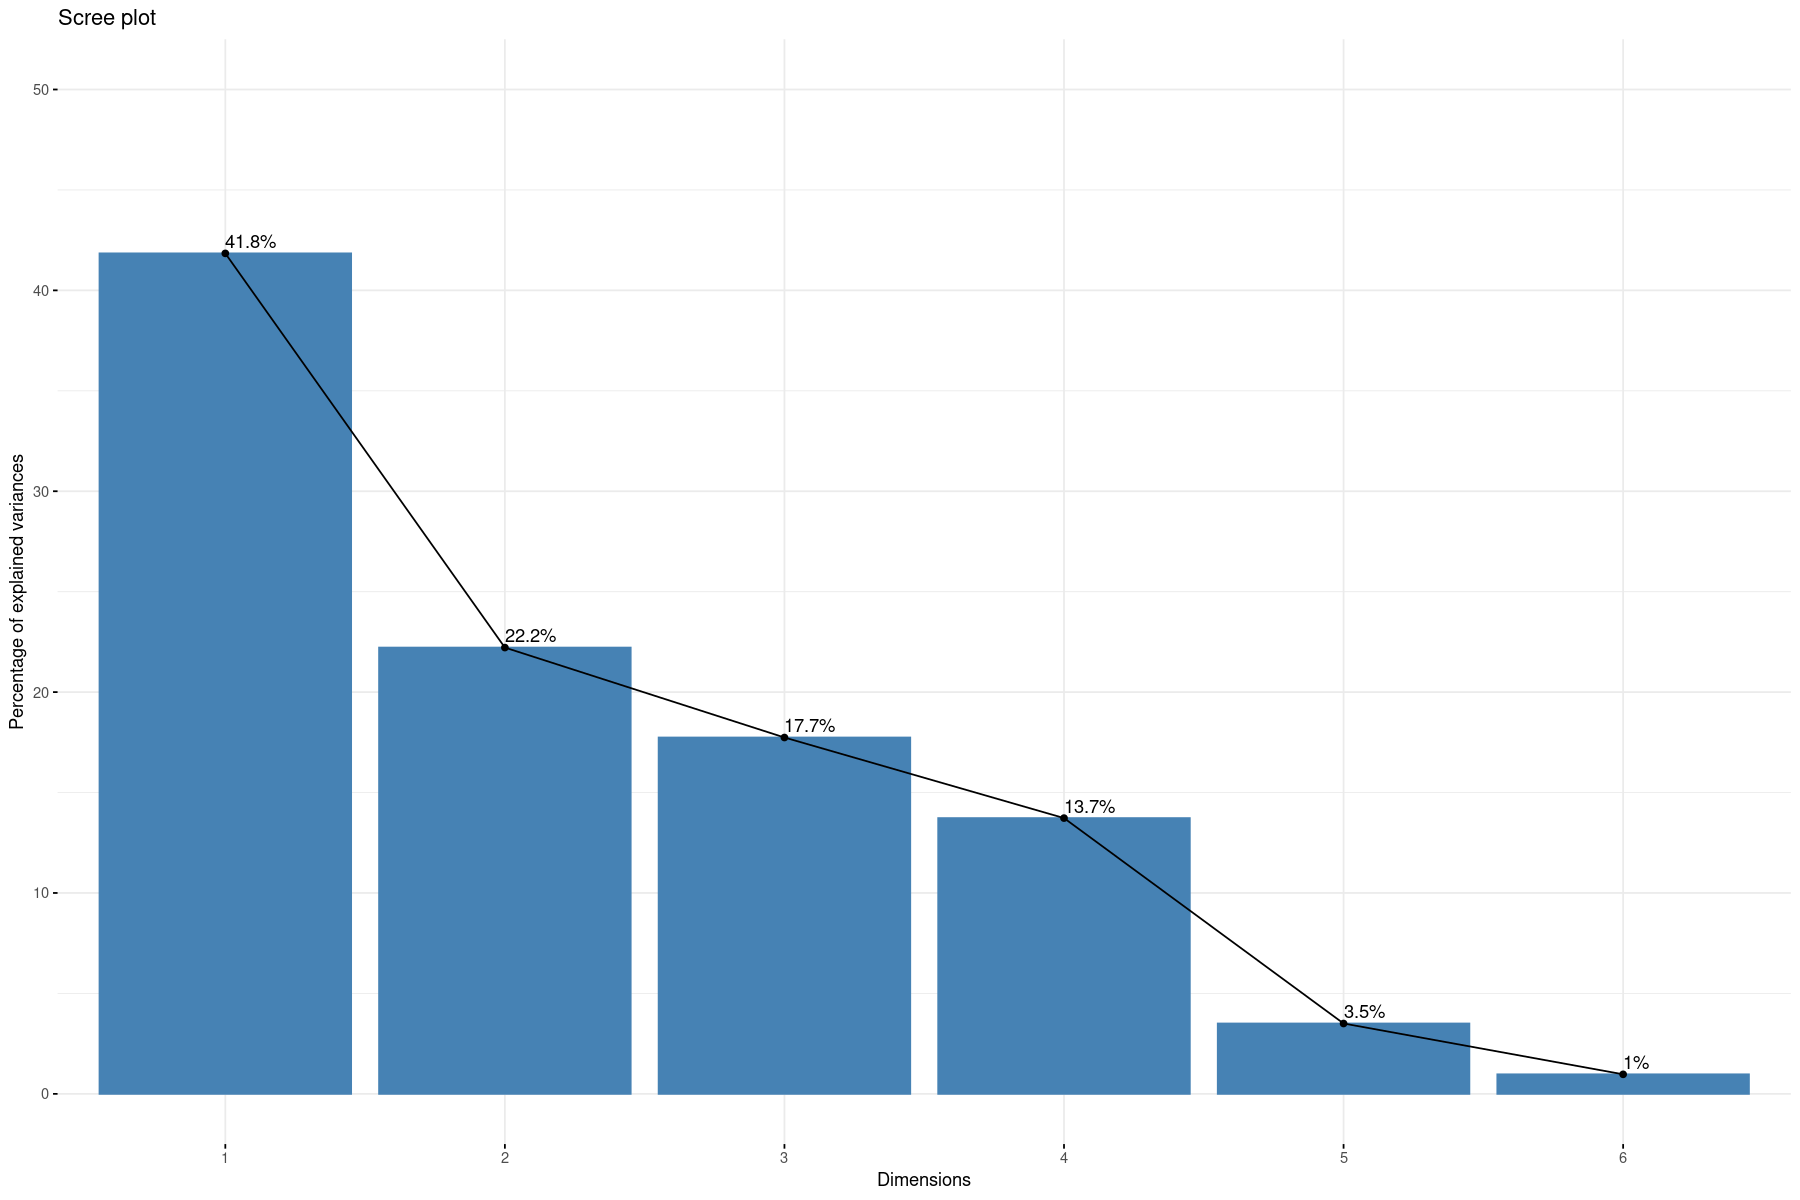

In [213]:
fviz_screeplot(pca_traits, addlabels = TRUE, ylim = c(0, 50))

In [214]:
# Extract loadings
pca_traits$loadings


Loadings:
           Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
amax        0.601  0.109  0.198         0.107  0.759
gs          0.169  0.718  0.287  0.391  0.301 -0.360
wue         0.475 -0.474  0.117 -0.231  0.558 -0.414
narea_g_m2  0.583               -0.129 -0.711 -0.349
d13c        0.199 -0.239 -0.588  0.743              
sla               -0.426  0.714  0.474 -0.278       

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.167  0.167  0.167  0.167  0.167  0.167
Cumulative Var  0.167  0.333  0.500  0.667  0.833  1.000

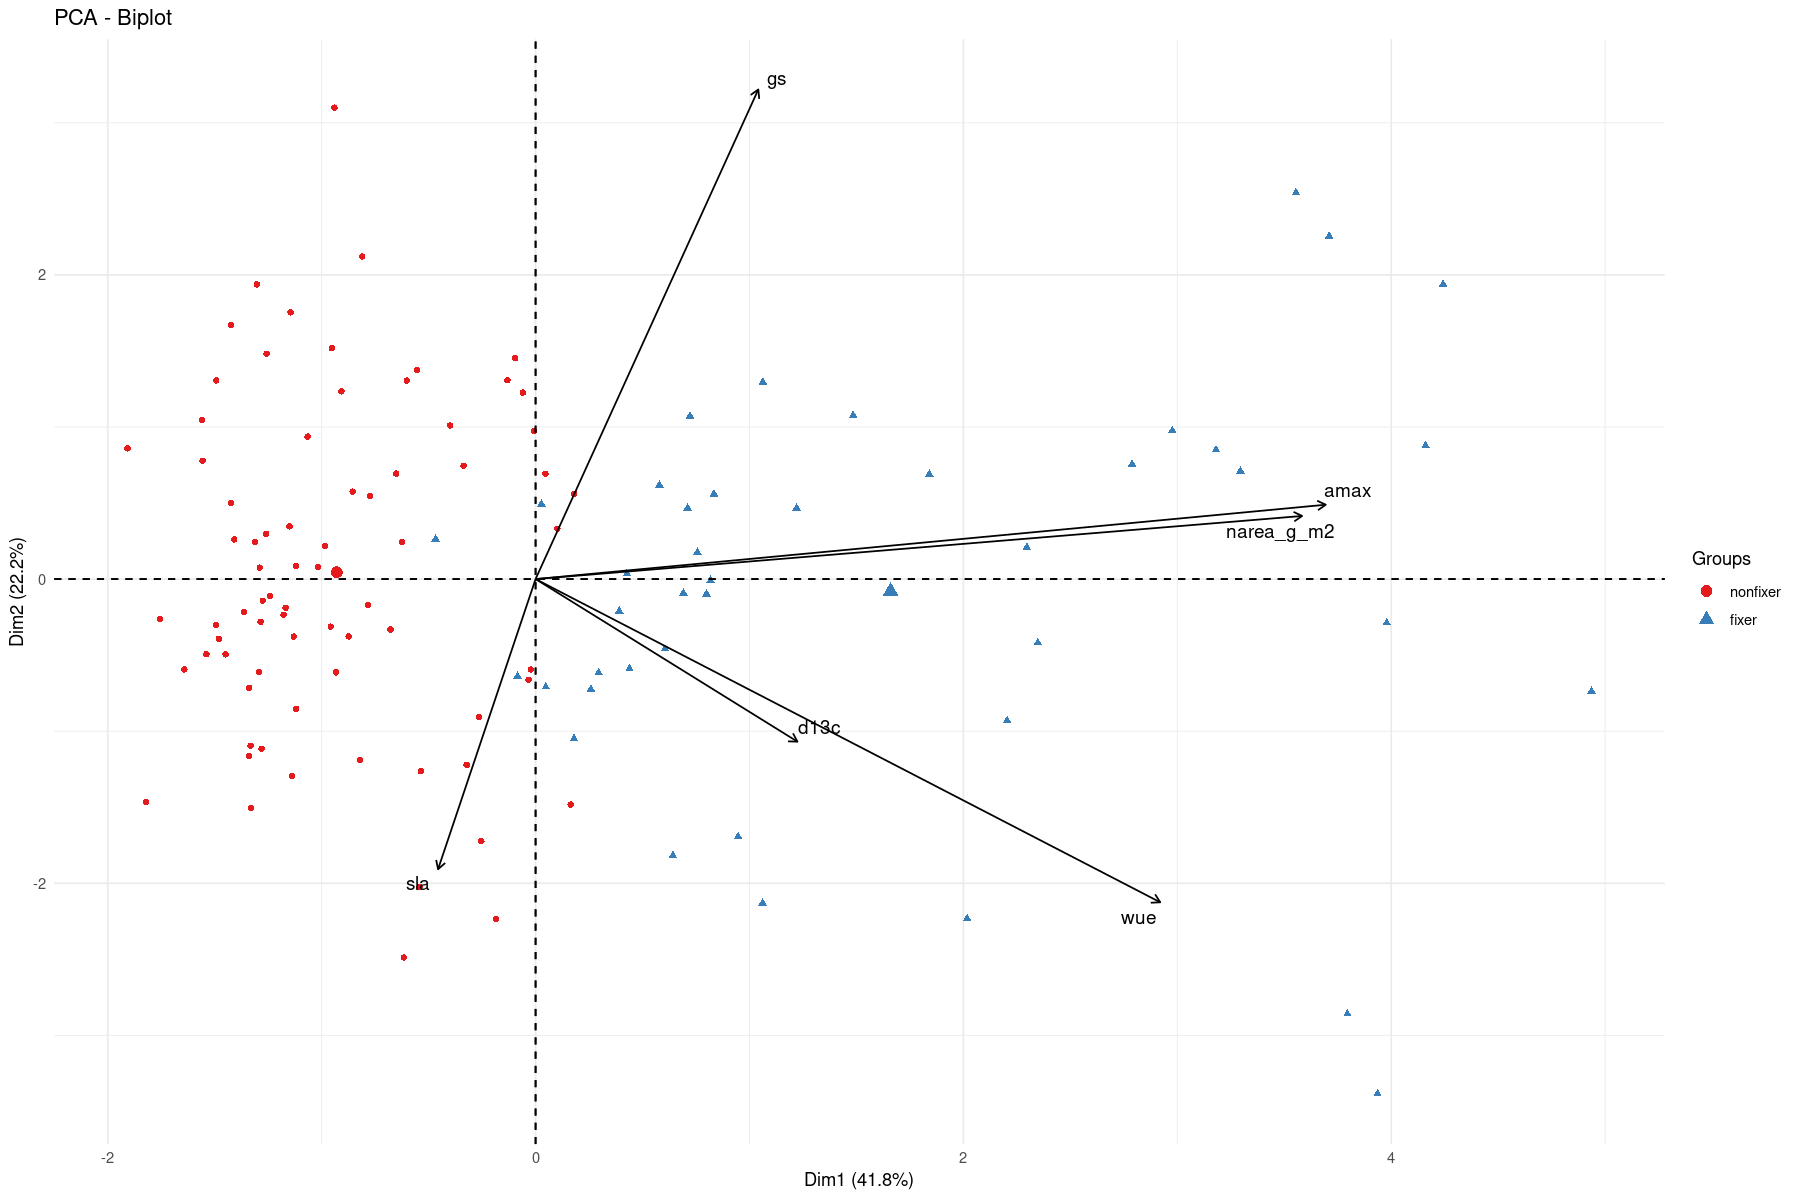

In [215]:
fviz_pca_biplot(pca_traits,axes = c(1, 2),

                # Add group
                habillage= data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

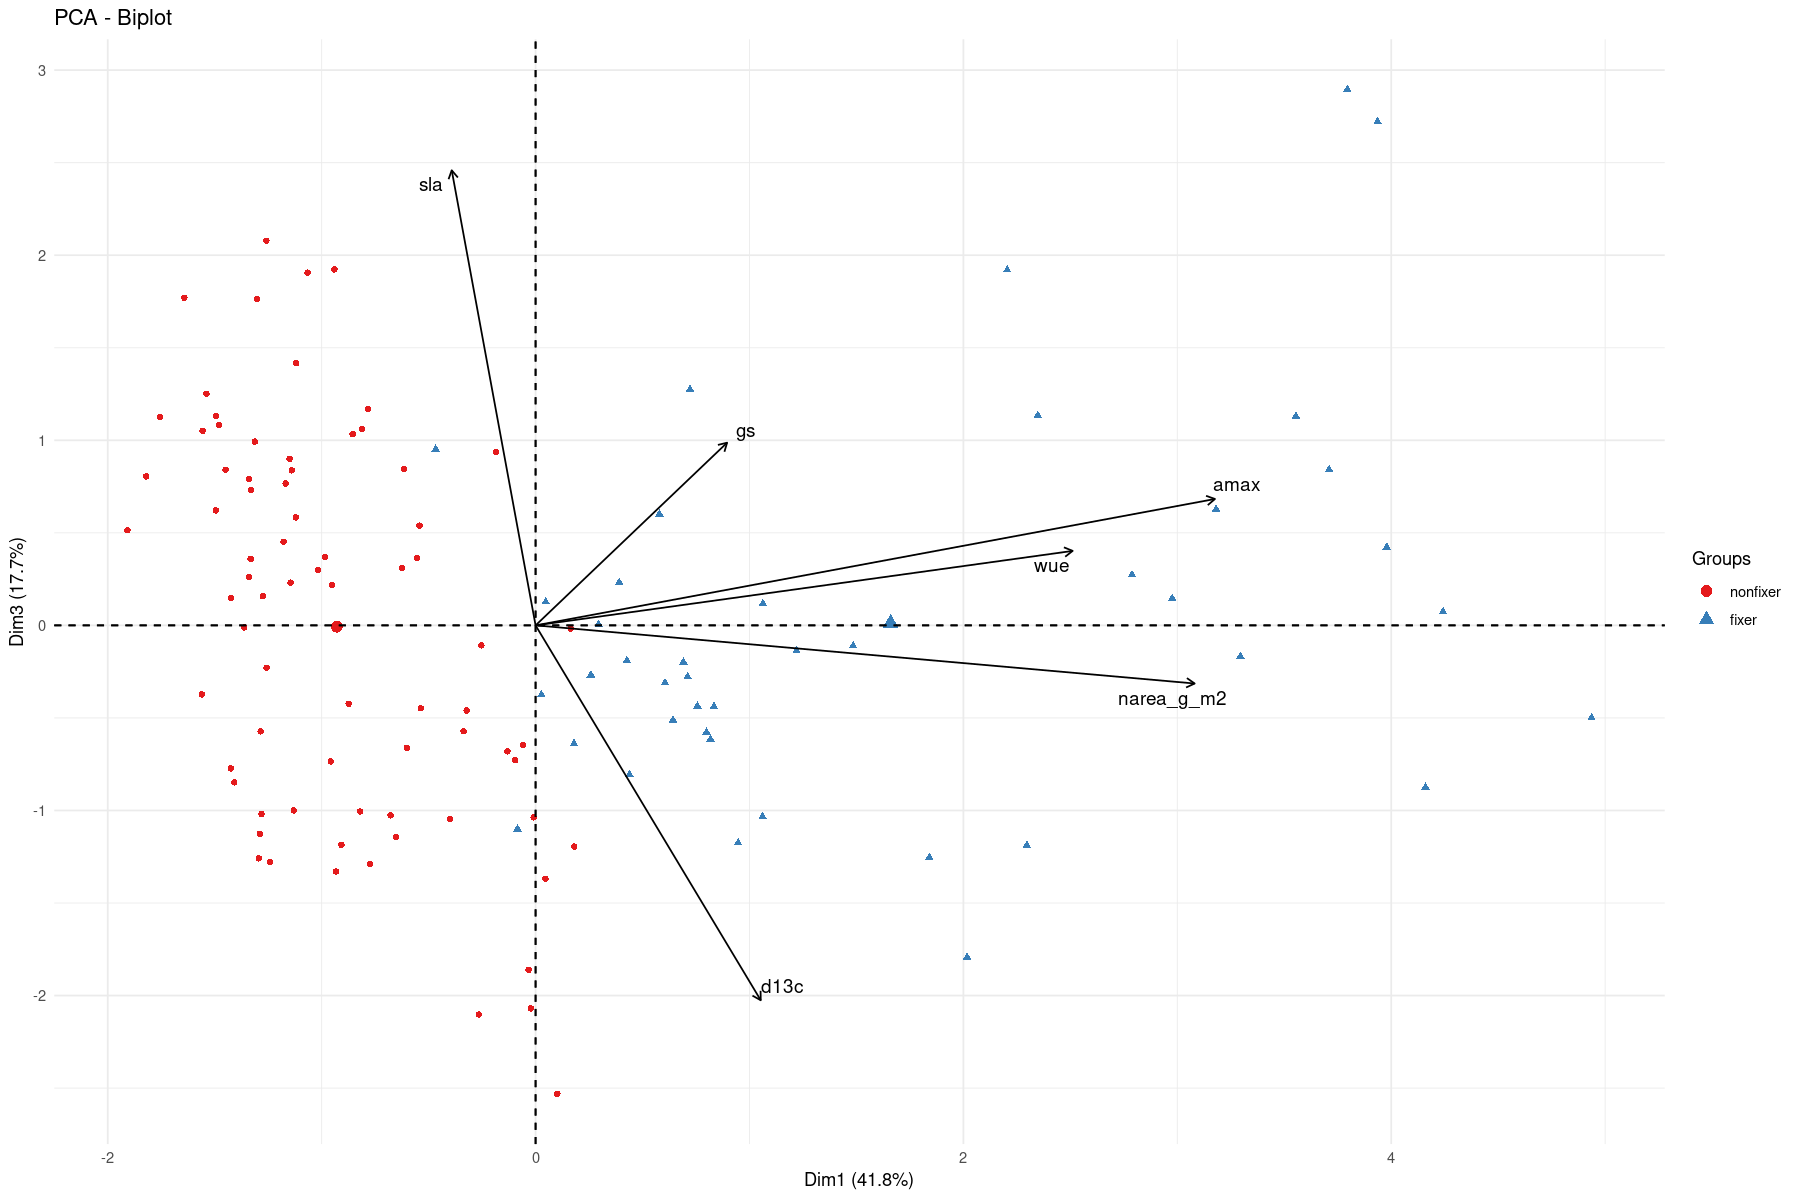

In [216]:
fviz_pca_biplot(pca_traits,axes = c(1, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

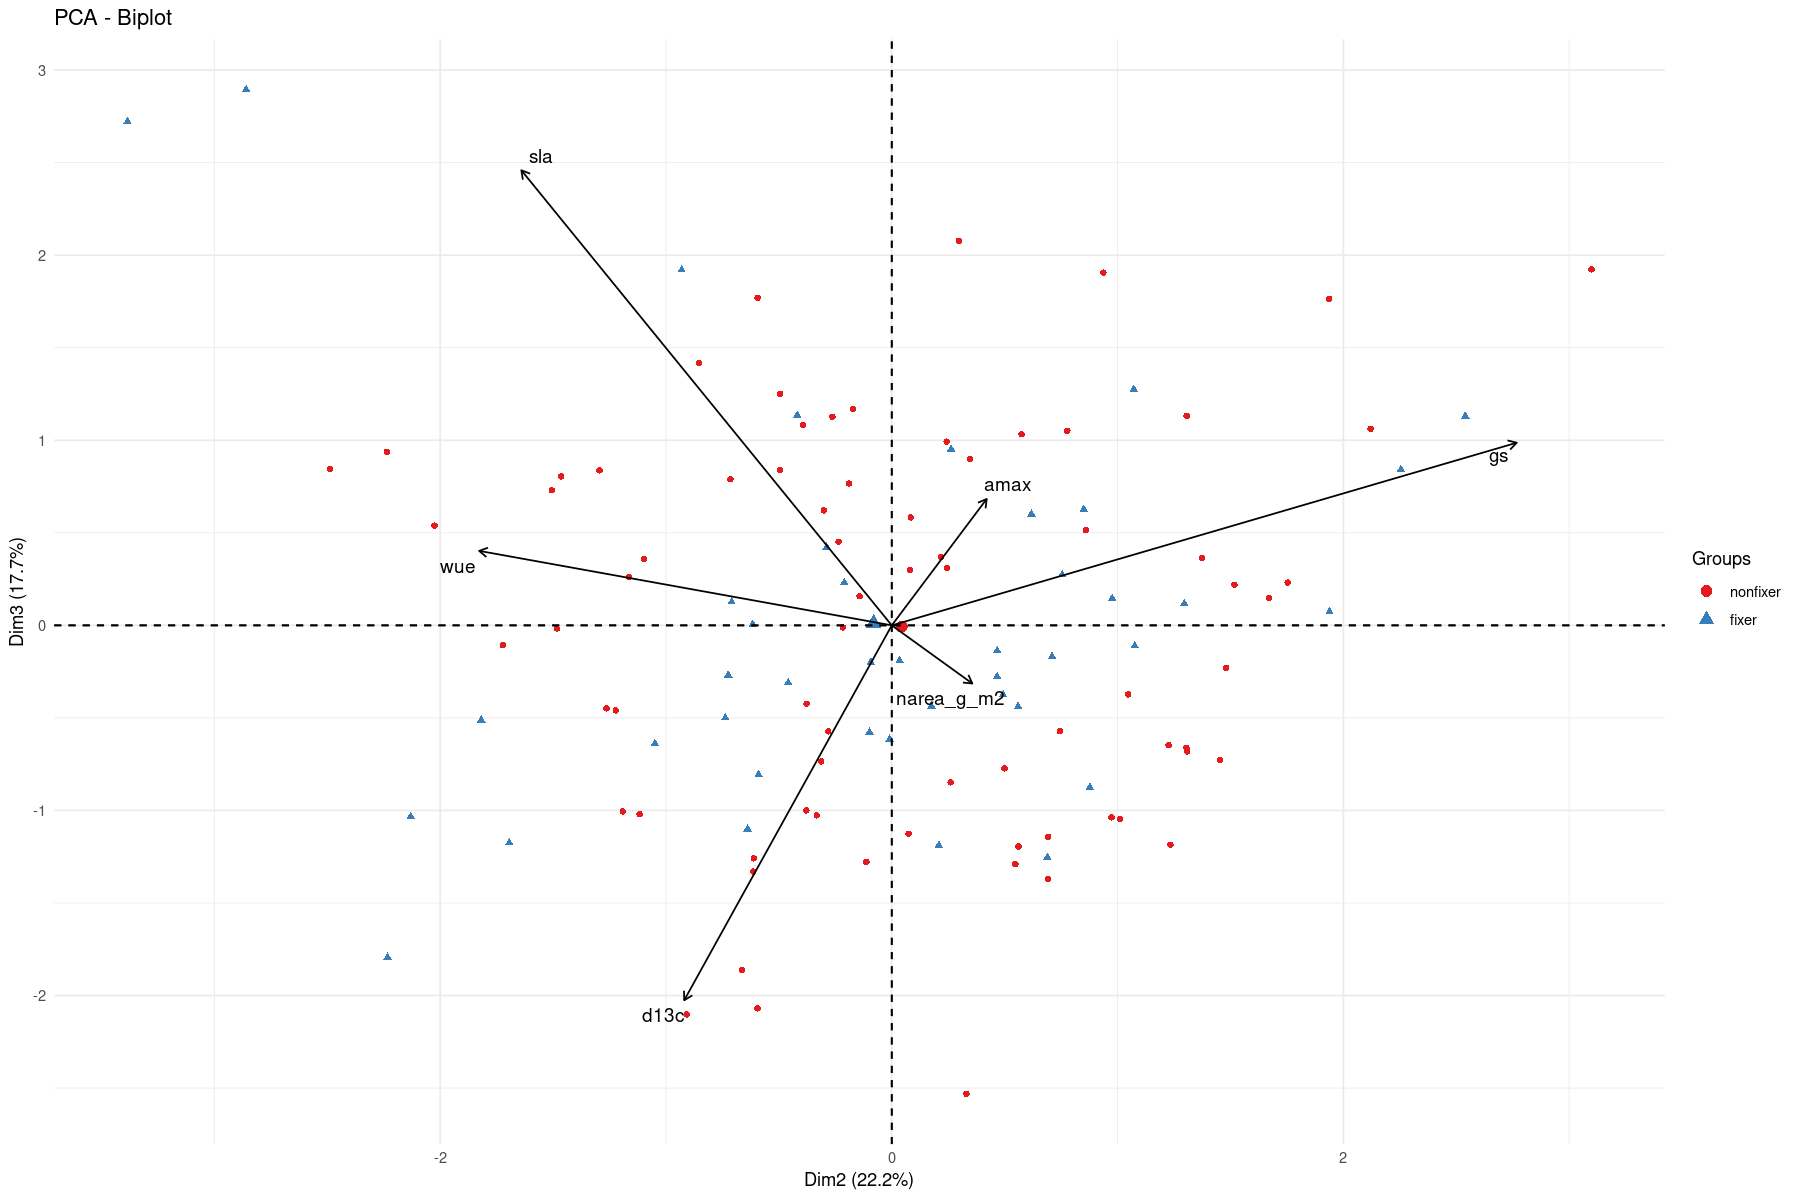

In [217]:
fviz_pca_biplot(pca_traits,axes = c(2, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

## Biplots interpretation
[PCA interpretation](https://wilkelab.org/SDS375/slides/dimension-reduction-1.html#18)

+ The first 3 PCs explains 81% (47.9,19.4,15.8) of the variability in the data
+ PC1 separates fixers from non-fixers
+ All traits contribute positively to PC1 

+ PC1 represents the overall high photosynthetic capacity 
+ PC2 represents the difference between stomatal conductance and SLA
+ PC3 represents the difference between d13c and SLA

## Regression model with PCs as independent variables

$$response\sim treatment*fixer*PCn\ + initial\ height\ + random(1|specie)

In [218]:
pca_scores <- scores(pca_traits)

In [219]:
# Extract PCs
data_traits_scaled$pc1 <- pca_scores[,1]
data_traits_scaled$pc2 <- pca_scores[,2]
data_traits_scaled$pc3 <- pca_scores[,3]


data_pcs <-
    data_traits_scaled %>%
    select(1:3, 10:12)

In [220]:
data_for_regression <-
    inner_join(data_for_models, data_pcs, , by = c("treatment","spcode", "nfixer")) %>%
    select(-c("amax", "gs",	"wue", "narea_g_m2", "d13c", "sla"))


Warning message in inner_join(data_for_models, data_pcs, , by = c("treatment", "spcode", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [221]:
# add t-ratio
emm_options(contrast = list(infer = c(TRUE, TRUE)))

In [298]:
# fit three-way interaction
model_pc_total_biomass <- lmer(total_biomass ~ treatment + nfixer+ pc1 + pc2 + pc3 +

                            # Two way interactions
                            # Treatments
                            treatment * pc1 +
                            treatment * pc2 +
                            treatment * pc3 +

                            # NFixer
                            nfixer * pc1 +
                            nfixer * pc2 +
                            nfixer * pc3 +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression)


In [299]:
# fit three-way interaction
model_pc_rgr <- lmer(rgr ~ treatment + nfixer+ pc1 + pc2 + pc3 +

                            # Two way interactions
                            # Treatments
                            treatment * pc1 +
                            treatment * pc2 +
                            treatment * pc3 +

                            # NFixer
                            nfixer * pc1 +
                            nfixer * pc2 +
                            nfixer * pc3 +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression)


In [300]:
model_pc_root_shoot <- lmer(root_shoot_ratio ~ treatment + nfixer+ pc1 + pc2 + pc3 +

                            # Two way interactions
                            # Treatments
                            treatment * pc1 +
                            treatment * pc2 +
                            treatment * pc3 +

                            # NFixer
                            nfixer * pc1 +
                            nfixer * pc2 +
                            nfixer * pc3 +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression)

## Model Assumptions

[1] "No variable specified inthe variables argument"


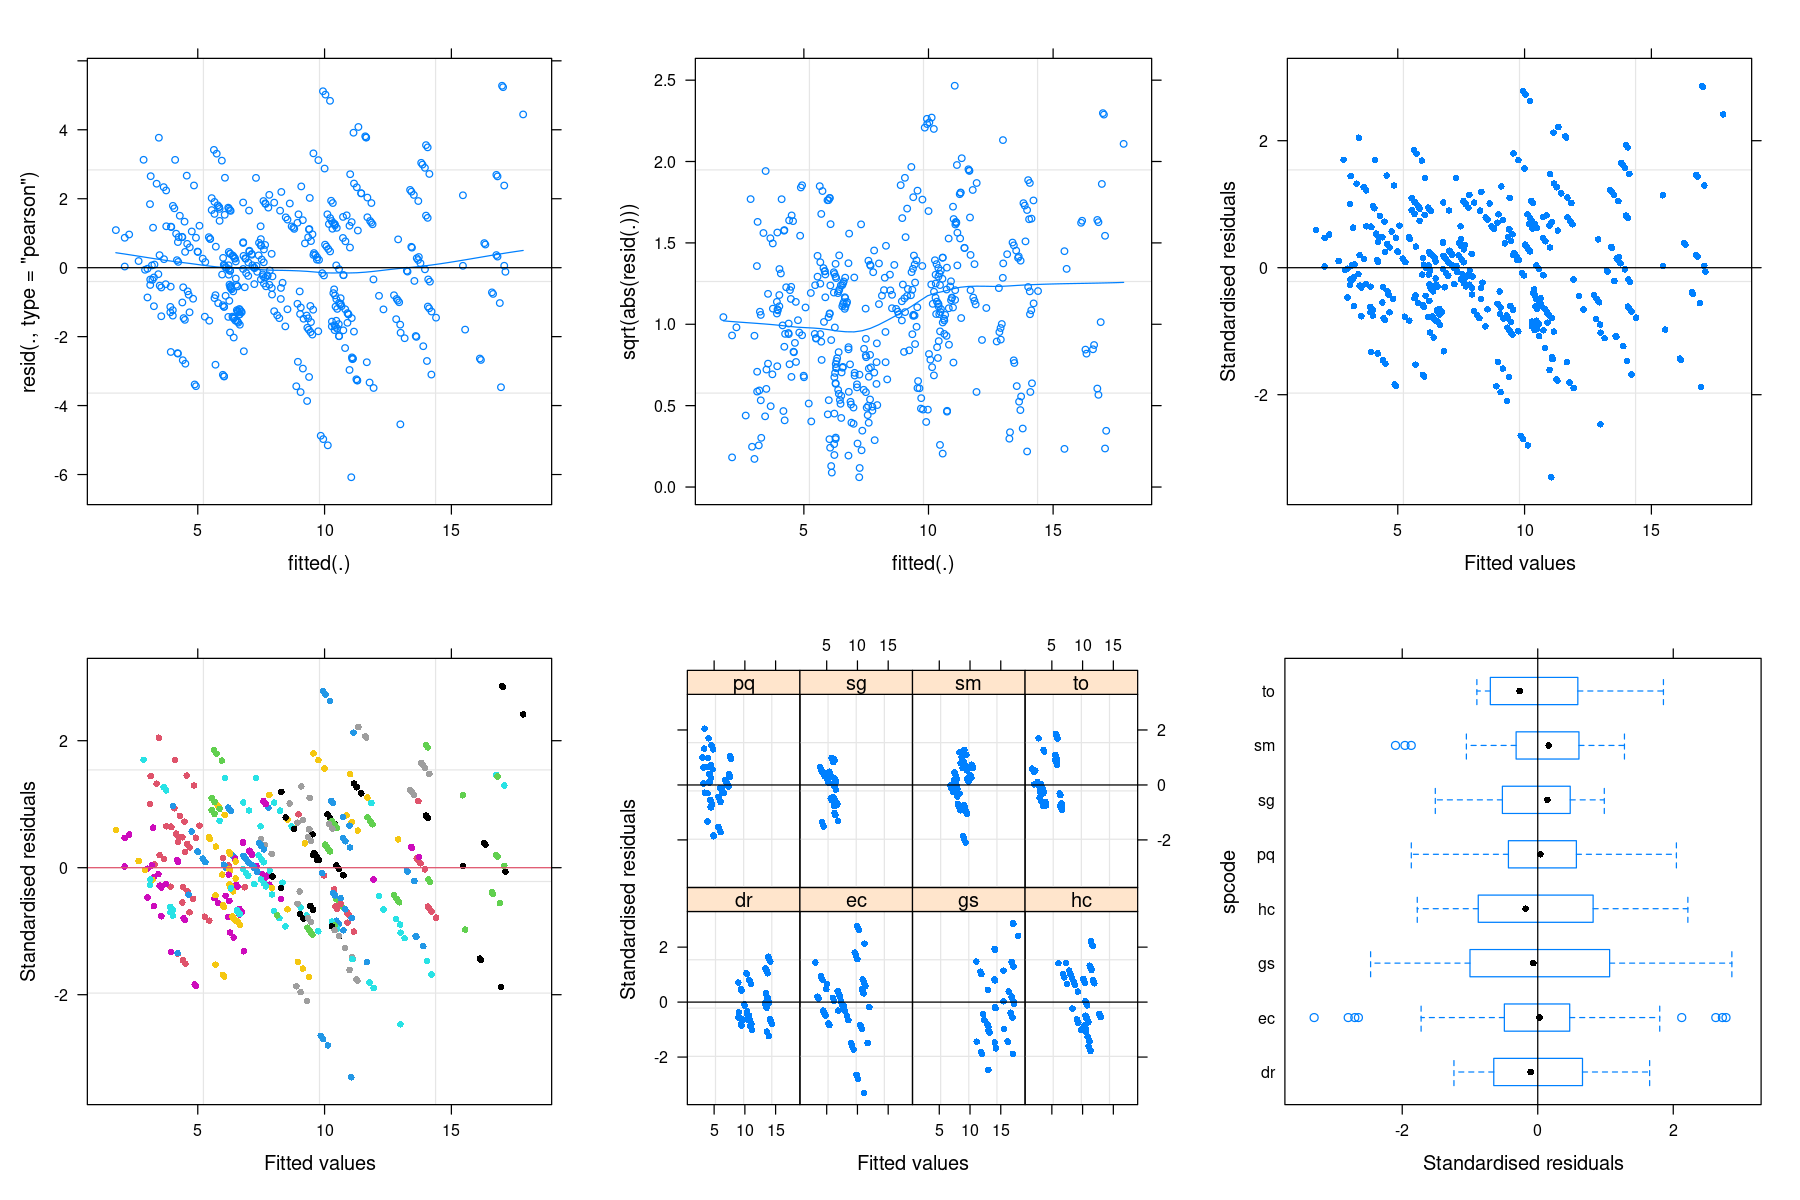

In [301]:
par(mfrow = c(3,3))
validation_plots(model_pc_total_biomass, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


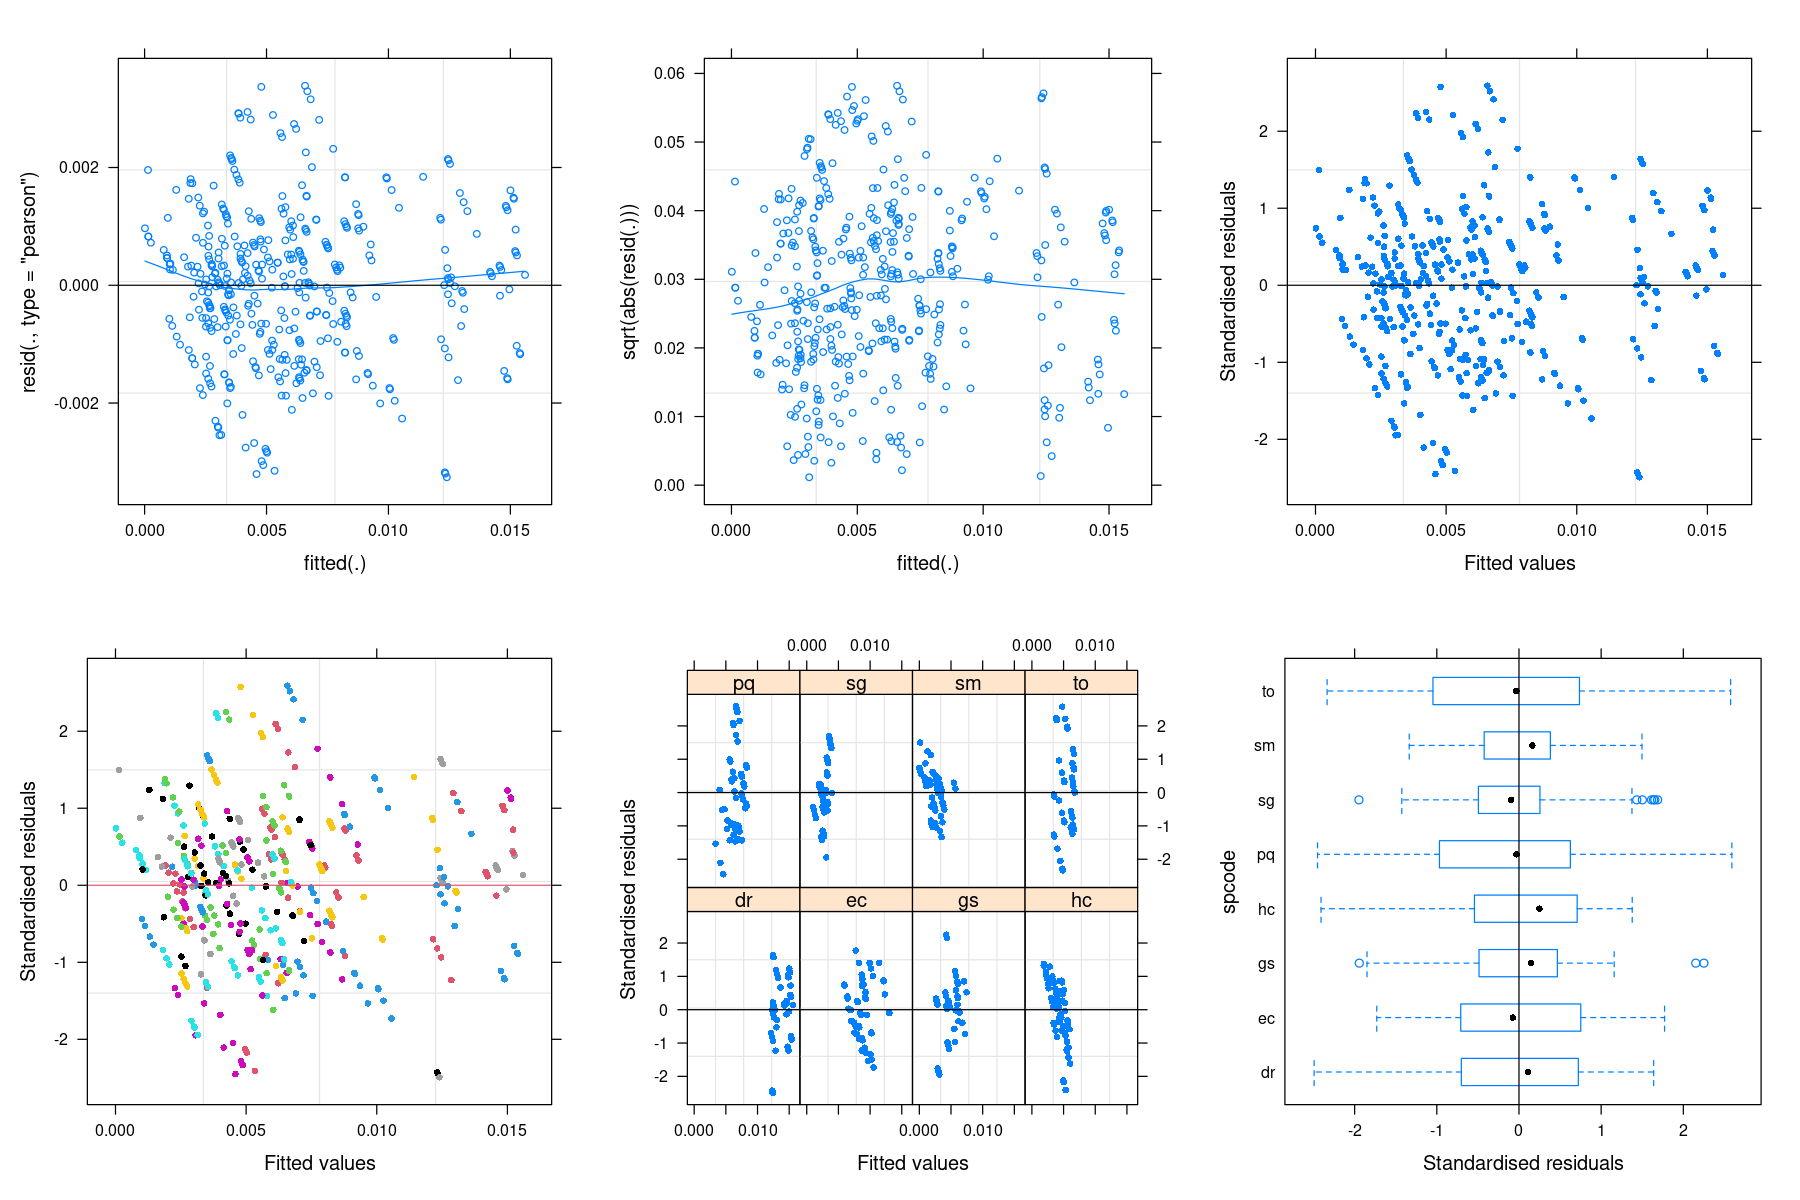

In [302]:
par(mfrow = c(3,3))
validation_plots(model_pc_rgr, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


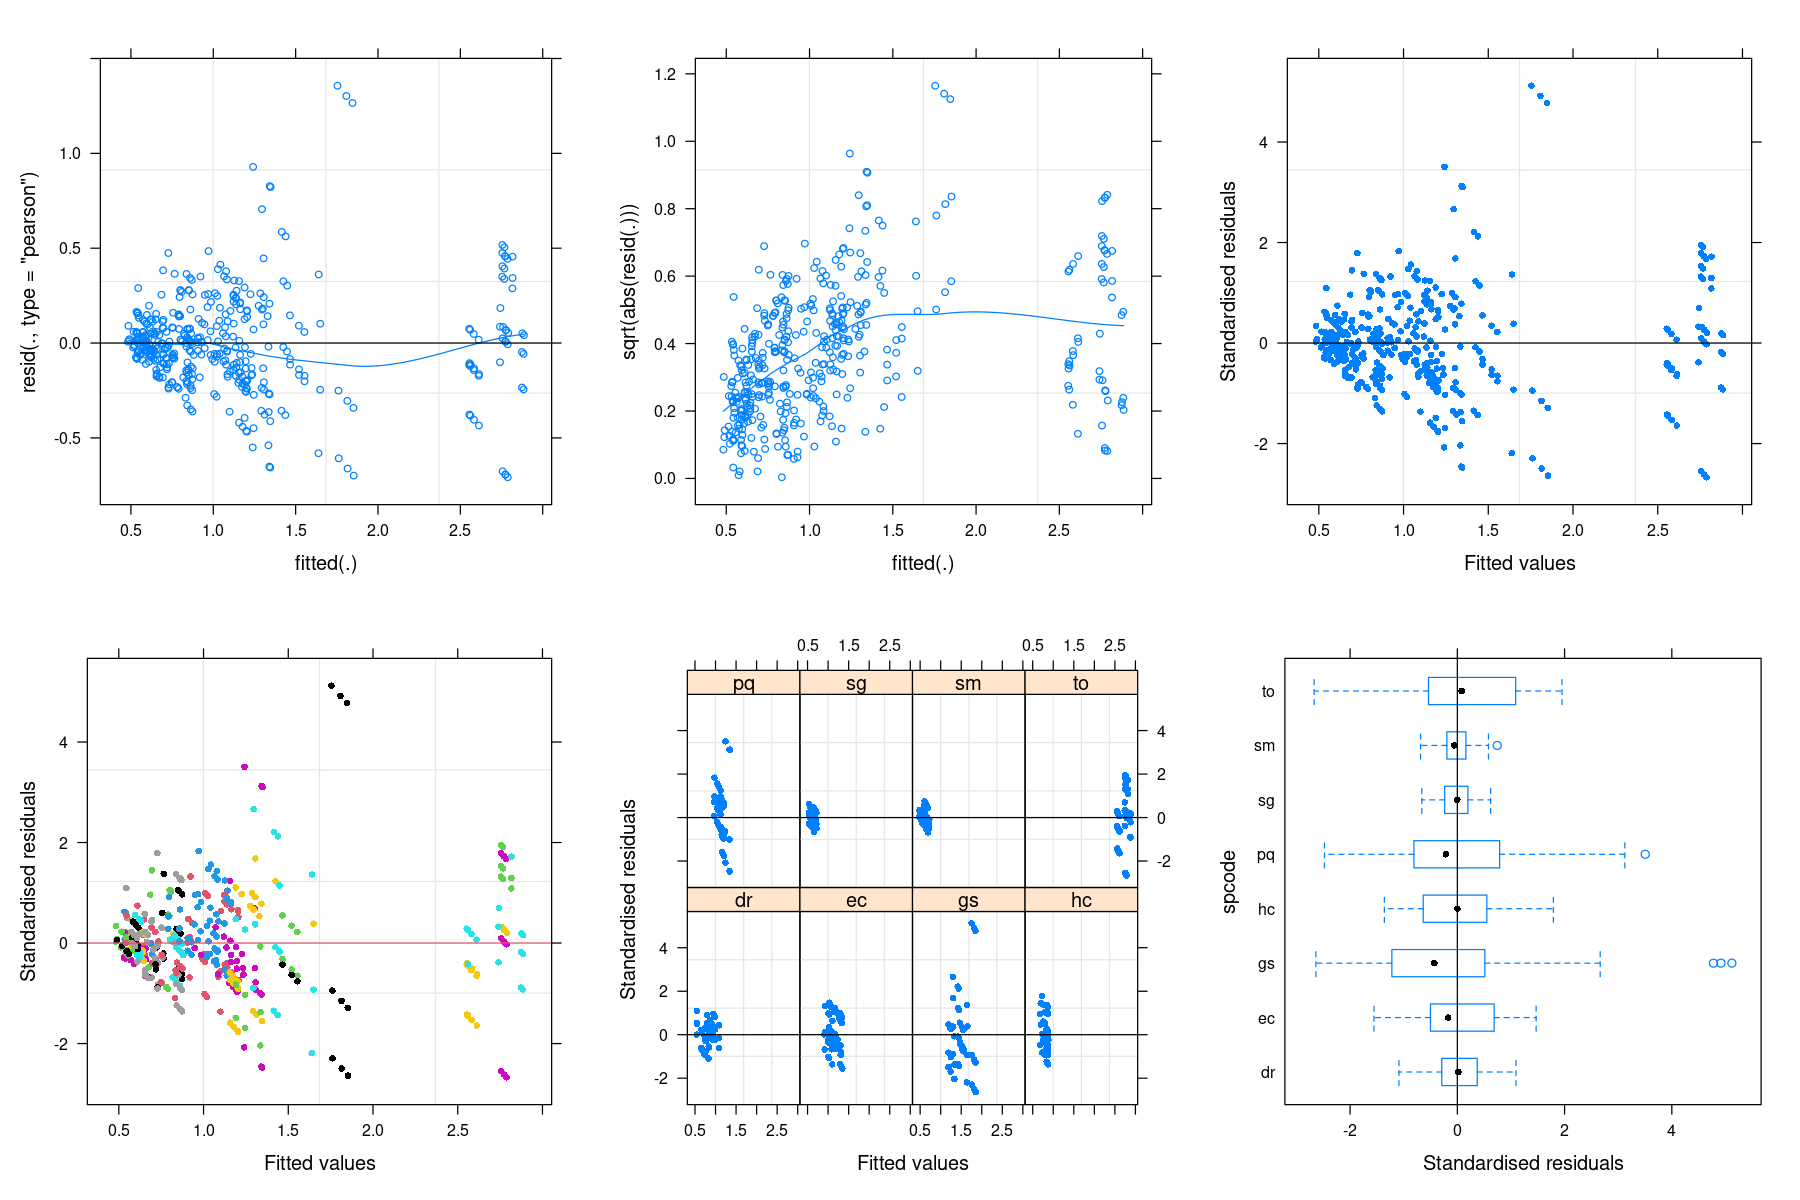

In [303]:
par(mfrow = c(3,3))
validation_plots(model_pc_root_shoot, data = data_for_models,group = "spcode")

## Model inference

### Anova tables

In [304]:
Anova(model_pc_total_biomass, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.5585888,1,9.524329,2.416877e-01
treatment,67.4799301,3,410.473659,1.723322e-35
nfixer,4.2820411,1,7.206533,7.615024e-02
pc1,3.0169205,1,413.684616,8.314414e-02
pc2,9.3497515,1,409.900532,2.376316e-03
pc3,3.0040074,1,413.978275,8.380346e-02
init_height,27.0707863,1,366.681841,3.270935e-07
treatment:pc1,7.3632768,3,411.327728,8.118587e-05
treatment:pc2,8.0682414,3,410.874816,3.105441e-05


In [305]:
Anova(model_pc_rgr, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),17.615464,1,7.333624,3.651272e-03
treatment,50.668089,3,409.136925,7.250585e-28
nfixer,6.336170,1,6.511361,4.242666e-02
pc1,5.194811,1,412.388253,2.316465e-02
pc2,6.815657,1,408.831594,9.368368e-03
pc3,1.674098,1,411.604174,1.964360e-01
init_height,114.445343,1,411.670430,9.862344e-24
treatment:pc1,7.666409,3,409.793847,5.374429e-05
treatment:pc2,7.842113,3,409.361000,4.230901e-05


In [306]:
Anova(model_pc_root_shoot, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.235824e+01,1,6.872239,1.008444e-02
treatment,5.983297e+00,3,408.777841,5.347567e-04
nfixer,2.838983e-02,1,6.343188,8.714408e-01
pc1,7.662499e-04,1,411.206403,9.779298e-01
pc2,5.430678e-01,1,408.563018,4.615871e-01
pc3,3.248782e-01,1,410.559897,5.690024e-01
init_height,9.109826e-02,1,413.961131,7.629371e-01
treatment:pc1,6.318284e+00,3,409.266625,3.384325e-04
treatment:pc2,8.264742e-02,3,408.935863,9.694621e-01


### Post-Hoc: Tukey's test

### Total Biomass

In [308]:
# compare slopes of lines for treatment X PC1 iteraction
# summary(emtrends(model = fit_sat, ~agef, var="SATV"), infer=TRUE)
#emtrends(pca_mod_agr_1, pairwise ~ treatment|PC1, var = "PC1")

emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "pc1")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.7690178| 0.2178222| 413.8689| -1.3308900| -0.2071456| -3.5304838| 0.0025925|
|no_additions - plus_water             | -0.1901835| 0.2052410| 410.5377| -0.7196200|  0.3392530| -0.9266348| 0.7905955|
|no_additions - plus_water_nutrients   | -0.7014304| 0.1909852| 413.7086| -1.1940774| -0.2087834| -3.6726943| 0.0015426|
|plus_nutrients - plus_water           |  0.5788343| 0.2337130| 410.6065| -0.0240476|  1.1817162|  2.4766887| 0.0650992|
|plus_nutrients - plus_water_nutrients |  0.0675874| 0.2164495| 409.4512| -0.4907683|  0.6259431|  0.3122548| 0.9894392|
|plus_water - plus_water_nutrients     | -0.5112469| 0.1759082| 409.8628| -0.9650199| -0.0574740| -2.9063285| 0.0200708|

In [309]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "pc2")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -1.0442168| 0.3401669| 409.9857| -1.9217108| -0.1667228| -3.0697188| 0.0121974|
|no_additions - plus_water             | -1.8482033| 0.3784069| 410.0145| -2.8243409| -0.8720657| -4.8841688| 0.0000089|
|no_additions - plus_water_nutrients   | -0.8816113| 0.3473817| 412.7579| -1.7776919|  0.0144694| -2.5378745| 0.0557144|
|plus_nutrients - plus_water           | -0.8039865| 0.3292250| 409.9085| -1.6532554|  0.0452824| -2.4420580| 0.0709641|
|plus_nutrients - plus_water_nutrients |  0.1626055| 0.3367803| 413.1285| -0.7061252|  1.0313363|  0.4828238| 0.9628817|
|plus_water - plus_water_nutrients     |  0.9665921| 0.3289109| 409.8143|  0.1181326|  1.8150515|  2.9387655| 0.0182209|

In [310]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "pc3")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.4076071| 0.3242590| 412.8023| -1.2440416|  0.4288274| -1.2570419| 0.5908644|
|no_additions - plus_water             |  0.4626414| 0.3239005| 409.6586| -0.3728946|  1.2981774|  1.4283440| 0.4823405|
|no_additions - plus_water_nutrients   | -0.5038761| 0.2305849| 412.3329| -1.0986786|  0.0909264| -2.1852086| 0.1290388|
|plus_nutrients - plus_water           |  0.8702485| 0.3459454| 409.8016| -0.0221534|  1.7626504|  2.5155659| 0.0590039|
|plus_nutrients - plus_water_nutrients | -0.0962690| 0.3074163| 409.4870| -0.8892836|  0.6967457| -0.3131551| 0.9893499|
|plus_water - plus_water_nutrients     | -0.9665175| 0.3173165| 408.9287| -1.7850752| -0.1479598| -3.0459104| 0.0131395|

### RGR

In [312]:
emtrends(model_pc_rgr,
        pairwise ~ treatment,
        var = "pc1")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.0005710| 0.0001549| 411.5609| -0.0009706| -0.0001715| -3.6867104| 0.0014650|
|no_additions - plus_water             |  0.0000490| 0.0001458| 409.1475| -0.0003270|  0.0004250|  0.3360536| 0.9869116|
|no_additions - plus_water_nutrients   | -0.0003459| 0.0001358| 411.2728| -0.0006962|  0.0000043| -2.5478114| 0.0543088|
|plus_nutrients - plus_water           |  0.0006200| 0.0001660| 409.2034|  0.0001918|  0.0010482|  3.7353493| 0.0012215|
|plus_nutrients - plus_water_nutrients |  0.0002251| 0.0001537| 408.6244| -0.0001713|  0.0006216|  1.4647772| 0.4598425|
|plus_water - plus_water_nutrients     | -0.0003949| 0.0001249| 408.8213| -0.0007171| -0.0000727| -3.1615294| 0.0091130|

In [313]:
emtrends(model_pc_rgr,
        pairwise ~ treatment,
        var = "pc2")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.0003234| 0.0002415| 408.8403| -0.0009465|  0.0002997| -1.3388317| 0.5386992|
|no_additions - plus_water             | -0.0011855| 0.0002687| 408.8378| -0.0018786| -0.0004924| -4.4122268| 0.0000771|
|no_additions - plus_water_nutrients   | -0.0003129| 0.0002468| 410.3417| -0.0009495|  0.0003238| -1.2676060| 0.5841219|
|plus_nutrients - plus_water           | -0.0008621| 0.0002338| 408.8352| -0.0014652| -0.0002591| -3.6877807| 0.0014603|
|plus_nutrients - plus_water_nutrients |  0.0000105| 0.0002393| 410.6949| -0.0006069|  0.0006279|  0.0439777| 0.9999694|
|plus_water - plus_water_nutrients     |  0.0008726| 0.0002336| 408.8027|  0.0002702|  0.0014751|  3.7363640| 0.0012169|

In [314]:
emtrends(model_pc_rgr,
        pairwise ~ treatment,
        var = "pc3")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.0000863| 0.0002304| 410.4984| -0.0006807|  0.0005081| -0.3744854| 0.9820721|
|no_additions - plus_water             |  0.0010679| 0.0002300| 408.7208|  0.0004746|  0.0016612|  4.6434439| 0.0000274|
|no_additions - plus_water_nutrients   | -0.0001177| 0.0001638| 410.1843| -0.0005403|  0.0003050| -0.7181388| 0.8898629|
|plus_nutrients - plus_water           |  0.0011542| 0.0002457| 408.8107|  0.0005205|  0.0017879|  4.6985502| 0.0000212|
|plus_nutrients - plus_water_nutrients | -0.0000314| 0.0002183| 408.6407| -0.0005944|  0.0005317| -0.1437006| 0.9989405|
|plus_water - plus_water_nutrients     | -0.0011856| 0.0002253| 408.3854| -0.0017667| -0.0006044| -5.2627370| 0.0000014|

### Treatment effects

## Plots 

### Total Biomass

In [269]:
# plot that shit
cbbPalette <- c("#F0E442", "#009E73", "#56B4E9", "#0072B2")

total_biomass_predict <- ggpredict(model_pc_total_biomass, terms = c("pc1","treatment"))


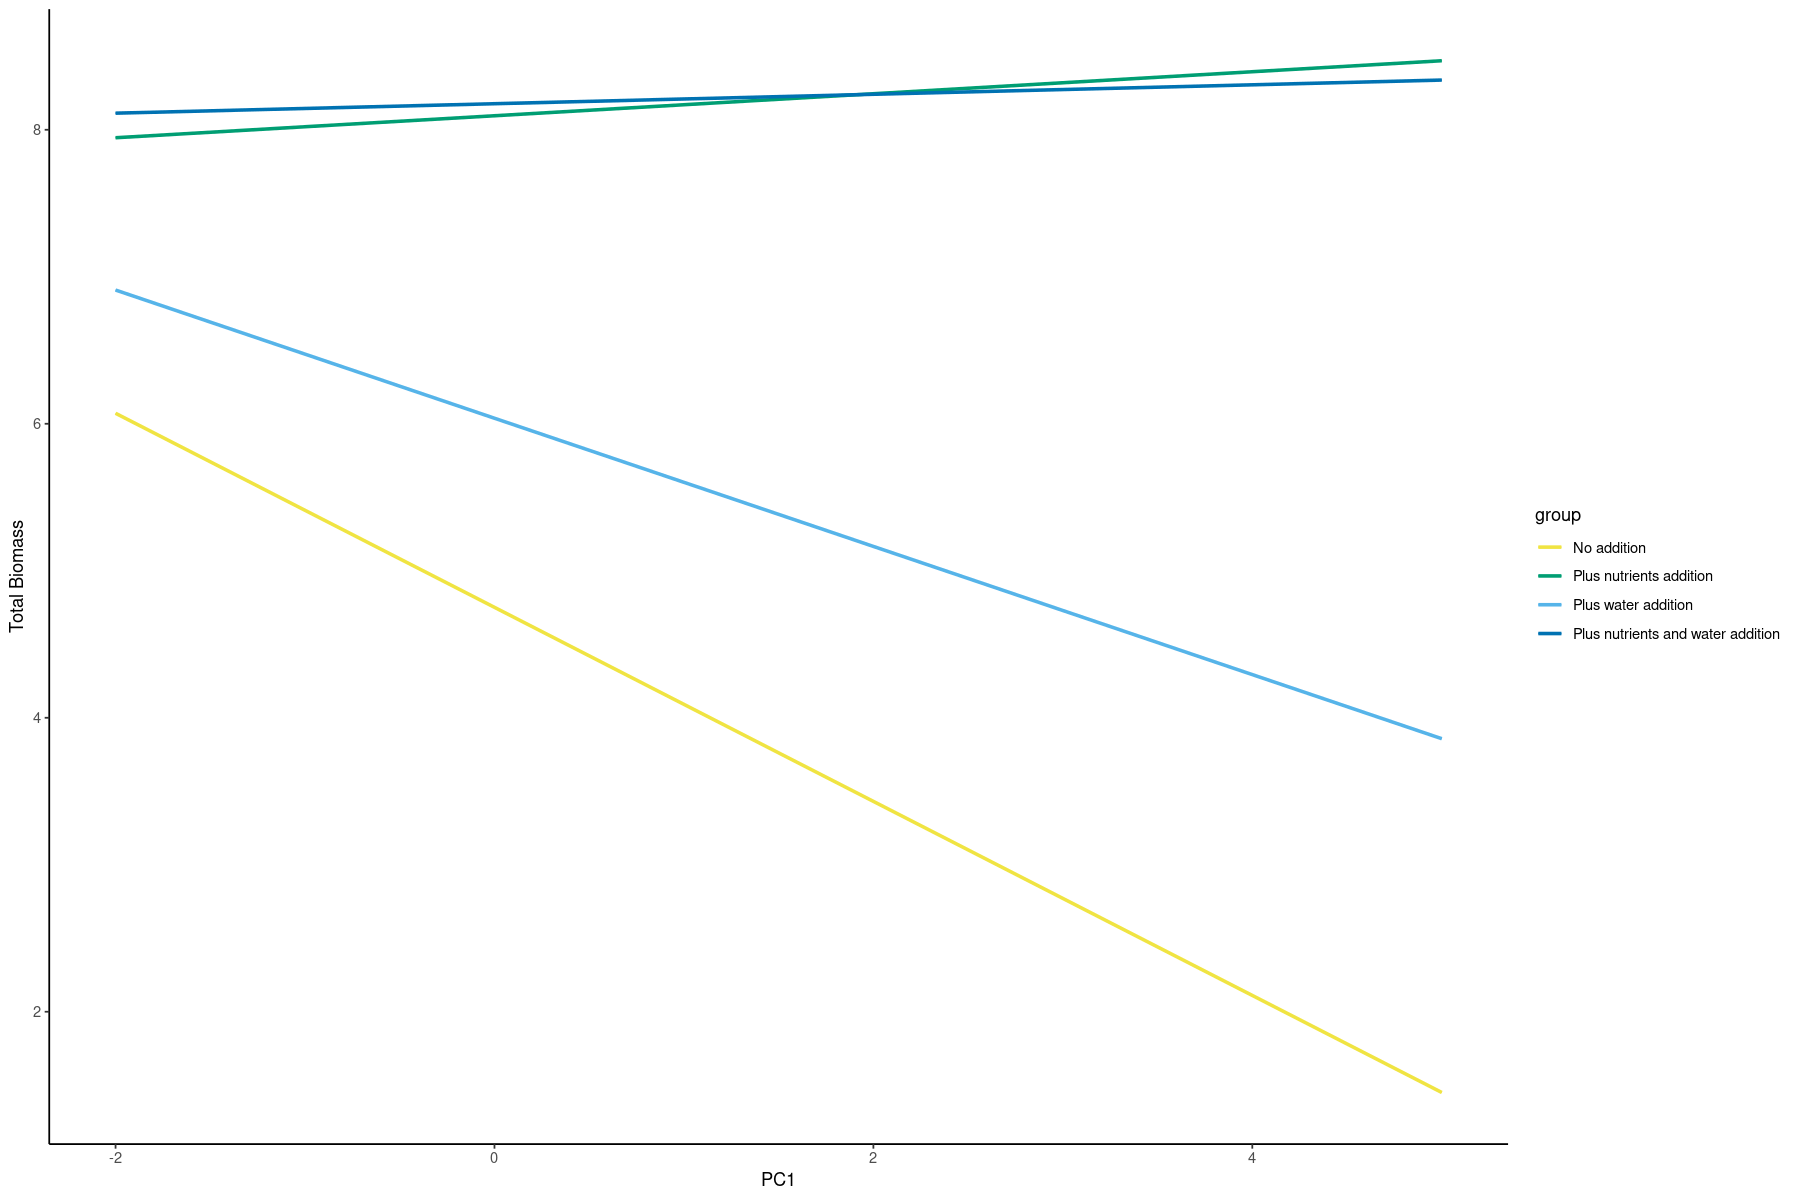

In [270]:
ggplot(total_biomass_predict, aes(x, predicted, colour = group)) +

                      geom_line()+
                      ylab("Total Biomass")+

                      xlab("PC1")+
                      theme_classic()+
                      scale_color_manual(values= cbbPalette,
                                        labels=c("No addition", "Plus nutrients addition",
                                                  "Plus water addition",
                                                 "Plus nutrients and water addition")
                                        ) +
                      geom_line(size=1)

### RGR

In [ ]:
pc2_predict <- ggpredict(model_pc_rgr, terms = c("pc2",, "nfixer"))

### Root-shoot ratio